In [2]:
%gui qt
%matplotlib notebook

import pandas as pd
import numpy as np
import scipy
from scipy import stats,signal
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import KF2D
import pickle
import os
import cpd
import glob
from scipy.signal import hilbert

from numpy import linalg as LA

from filters import butter_lowpass_lfilter, butter_highpass_lfilter
from pykalman import KalmanFilter
import peakdet
import pdb
from __future__ import division
from itertools import compress

fs = 25

This code opens previously analyzed data (pickle files), re-runs nystagmus analysis, and saves the new data to the dataframe, and saves the dataframe to BOTH pickle and csv.

In [8]:
def calc_gains(x,y,start,end, angvel, gains, nyst_time):
    linfit = scipy.stats.linregress(x[start:end],y[start:end]) 
    slopes.append(linfit.slope)
    if np.abs(linfit.slope/rot_speed) < 5:
        #nyst_bool[start:end] = True
        angvel.append(np.mean(w[start:end]))
        gains.append(linfit.slope/rot_speed)
        nyst_time.append(T[int(start)])
    return angvel, gains, nyst_time 

def monotonic(x):
    dx = np.diff(x)
    return np.all(dx <= 0) or np.all(dx >= 0)

def getFileInfo(filename):
    Date = filename[-12:-6]
    ID = int(filename[:2])
    Speed = float(filename[3:5])
    try:
        Date = int(Date)
        print(filename)
    except ValueError:
        print(Date)
        print('Filename is {}'.format(filename))
        print('Date not readible, enter manually')
        Date = input("Enter date ('YYMMDD'): ")
    return Date, ID, Speed

def getLocations(maxes, mins, halfpt):
    early_max = np.array(maxes<halfpt)
    late_max = np.array(maxes>halfpt)
    early_min = np.array(mins<halfpt)
    late_min = np.array(mins>halfpt)

    if rot_dir.upper() =='CW':
        #If rotation is CW, mins start the detection
        #The second half of the list is the counter rotation. If no rotation, make T_break = # of frames
        print('First rotation is CW')
        start_loc = list(maxes[early_max]+3) + list(mins[late_min]+3)
        end_loc = list(mins[early_min]+4) + list(maxes[late_max]+4)

    else:
        print('First rotation is CCW')
        start_loc = list(mins[early_min]+4) + list(maxes[late_max]+4)
        end_loc = list(maxes[early_max]+3) + list(mins[late_min]+3)
    return start_loc, end_loc

def setNystagmus(data,halfpt=4000,check=True):
    '''This function sets up data for nystagmus processing. It finds peaks, locations of potential
    nystagmus events, and determines a halfpoint (where rotation changes direction). One must enter
    the angular data to be analized (theta, omega, etc), '''
    dp = 10# distance between peaks (~25-30 is usually good when using w)
    if rot_speed > dp:
        dp = rot_speed-10
    [maxes,mins] = peakdet.peakdet(data,dp) #(w_deg,dp)
    maxes = np.array(list(map(int, maxes.T[0]))) # take the indeces of detection, and convert to int for indexing
    mins = np.array(list(map(int, mins.T[0])))# T[mins]

    #When CW, starts = mins, when CCW starts = maxes
    #TODO: adjust with long videos, adjust for length of movie (use this for HW too!)
#     halfpt = int(len(T)/2)

#     T_break = 120  #time (s) of change in rotation #TODO- make user input!
#     halfpt = np.where(np.round(T,1)==T_break)
#     halfpt = np.round(len(T)/2)

    start_loc, end_loc = getLocations(maxes, mins, halfpt)
    print('Start length is {} and end length is {}'.format(len(start_loc),len(end_loc)))

    #adjust for errors
    if end_loc[0]<=start_loc[0]:
        end_loc = end_loc[1:]
        print('Errors adjusted.')
        print('Start length is {} and end length is {}'.format(len(start_loc),len(end_loc)))

    if start_loc[-1]>end_loc[-1]:
        start_loc = start_loc[:-1]
        print('Errors adjusted.')
        print('Start length is {} and end length is {}'.format(len(start_loc),len(end_loc)))

    if len(np.where(start_loc<end_loc[0])[0])>1:
        L = len(np.where(start_loc<end_loc)[0])
        start_loc = start_loc[L:]
        print('Errors adjusted.')
        print('Start length is {} and end length is {}'.format(len(start_loc),len(end_loc)))

    if check:
        plt.figure()
        plt.plot(theta_deg)
        plt.plot(start_loc,theta_deg[start_loc],'g.')
        plt.plot(end_loc,theta_deg[end_loc],'r.')
        plt.show()
        cont = input('Press any key to continue')

        #PRESS ANY KEY TO CONTINUE
    return maxes, mins, start_loc, end_loc, halfpt

def findNystagmus(data, start_loc, end_loc):
    slopes = []
    gains = []
    angvel = []
    nyst_time=[]
    numevents = 0
    nyst_bool = np.zeros(np.size(theta_deg),dtype=bool)

    if len(end_loc)<len(start_loc):
        counter = len(end_loc)
    else:
        counter = len(start_loc)

    #adjsut lengths of detection events. ASSUMES DIFFERENCE OF 1.
    if len(end_loc)<=len(start_loc):
        if rot_dir.upper()=='CW':
            #mins should start
            if end_loc[0]<start_loc[0]:
                end_loc=end_loc[1:]
        else:
            if start_loc[-1]>end_loc[-1]:
                start_loc = start_loc[:-1]

    print(start_loc[0], end_loc[0])

    for i in range(2,counter-1):
        if i > 2:
            start = start_loc[i]#int(locations[i-1])+5
            end = end_loc[i]#int(locations[i])-3#4
            length = end-start
            print(T[start],length)
            if start>=end or length<4:#length min was previously 6, adjust for faster speeds?
                continue
            elif length > 200:
                end = start+60#int(maxes[i-1])+300
            linfit = scipy.stats.linregress(T[start:end],theta_deg[start:end]) 
            slopes.append(linfit.slope)
            if linfit.rvalue**2 >= 0.85 and np.abs(linfit.slope/rot_speed) < 2:
                nyst_bool[start:end]=True
                angvel.append(np.mean(w[start:end]))
                gains.append(linfit.slope/rot_speed)
                nyst_time.append(T[int(start)])
                numevents += 1
            else:
                print(linfit.rvalue**2)

    mean_gain = np.nanmean(np.abs(gains))
    mean_ang_gain = np.nanmean(np.abs(angvel))/rot_speed
    if not np.all(nyst_bool==False):
        a = np.linspace(nyst_time[0],T[-1])

        plt.figure()
        plt.subplot(211)
        #plt.plot(subset_T,subset)
        plt.plot(T,theta_deg)
        for i in range(counter):
            if i > 2:
                plt.plot(T[start_loc[i]],theta_deg[start_loc[i]],'g+')
                plt.plot(T[end_loc[i]],theta_deg[end_loc[i]],'r+')

    #             plt.plot(T[int(locations[i-1])+5],theta_deg[int(locations[i-1])+5],'g+') #start of fit region
    #             plt.plot(T[int(locations[i])-5],theta_deg[int(locations[i]-5)],'r+') #end of fit region, T[int(locations[i])-4]
        plt.xlim((T[0],T[-1]+20))
        plt.ylabel("Head angle (deg)")
        plt.title(filename)


        plt.subplot(212)
        plt.plot(nyst_time,np.abs(gains),'.-', label='Gain from $\Theta$')
        #plt.plot(np.abs(angvel)/6,'.-',label='Gain from $\omega$')
        plt.errorbar(a[0]-1,np.mean(np.abs(gains[:-1])),\
                     yerr=np.std(np.abs(gains[:-1]))/len(gains[:-1]),\
                     fmt='bo',label='Mean = {:.3}'.format(mean_gain))
    #     plt.errorbar(a[0]-1,np.mean(np.abs(angvel)/6),\
    #                  yerr=np.std(np.abs(angvel)/6),\
    #                  fmt='ro',label='Mean = {}'.format(mean_ang_gain))

        plt.plot(a,np.ones(np.size(a)),'k:')
        plt.xlim((T[0],T[-1]+20))
        plt.ylabel("Absolute value gain ($\omega_h/ \omega_s$)")
        plt.xlabel('Time (s)')

        #plt.title('Calculating gain between nystagmus events')
        plt.legend()
        plt.show()
    else:
        print("No nystagmus events found")
        
    return nyst_bool, numevents

def saveProcessed(proc_pd,filename)
    print(filename)
    #overwrite old data in DataFrame
    proc_pd['nyst_bool']=nyst_bool

    #overwrite previous pickle
    proc_pd.to_pickle(filename)

    #save csv
    csvname = filename[:-3]+'.csv'
    proc_pd.to_csv(csvname)
    print(csvname)

In [9]:
os.chdir('/Users/sazamore/Documents/Visuomotor/2-Processed_data/')
# os.chdir('/Users/sazamore/Documents/Visuomotor/1-Raw_data/')

files = glob.glob('94*processed.csv')

filename = files[14]
print(len(files))
Date, ID, rot_speed = getFileInfo(filename)

# proc_pd = pd.read_pickle(filename)
proc_pd = pd.read_csv(filename)

print("ID is {}, Rotation speed is {}, and Date is {}.".format(ID,rot_speed,Date))
rot_speed *= 6

15
rocess
Filename is 94_02rpm_170329-processed.csv
Date not readible, enter manually
Enter date ('YYMMDD'): 170329
ID is 94, Rotation speed is 2.0, and Date is 170329.


First rotation is CW
Start length is 129 and end length is 127
Errors adjusted.
Start length is 128 and end length is 127


<IPython.core.display.Javascript object>


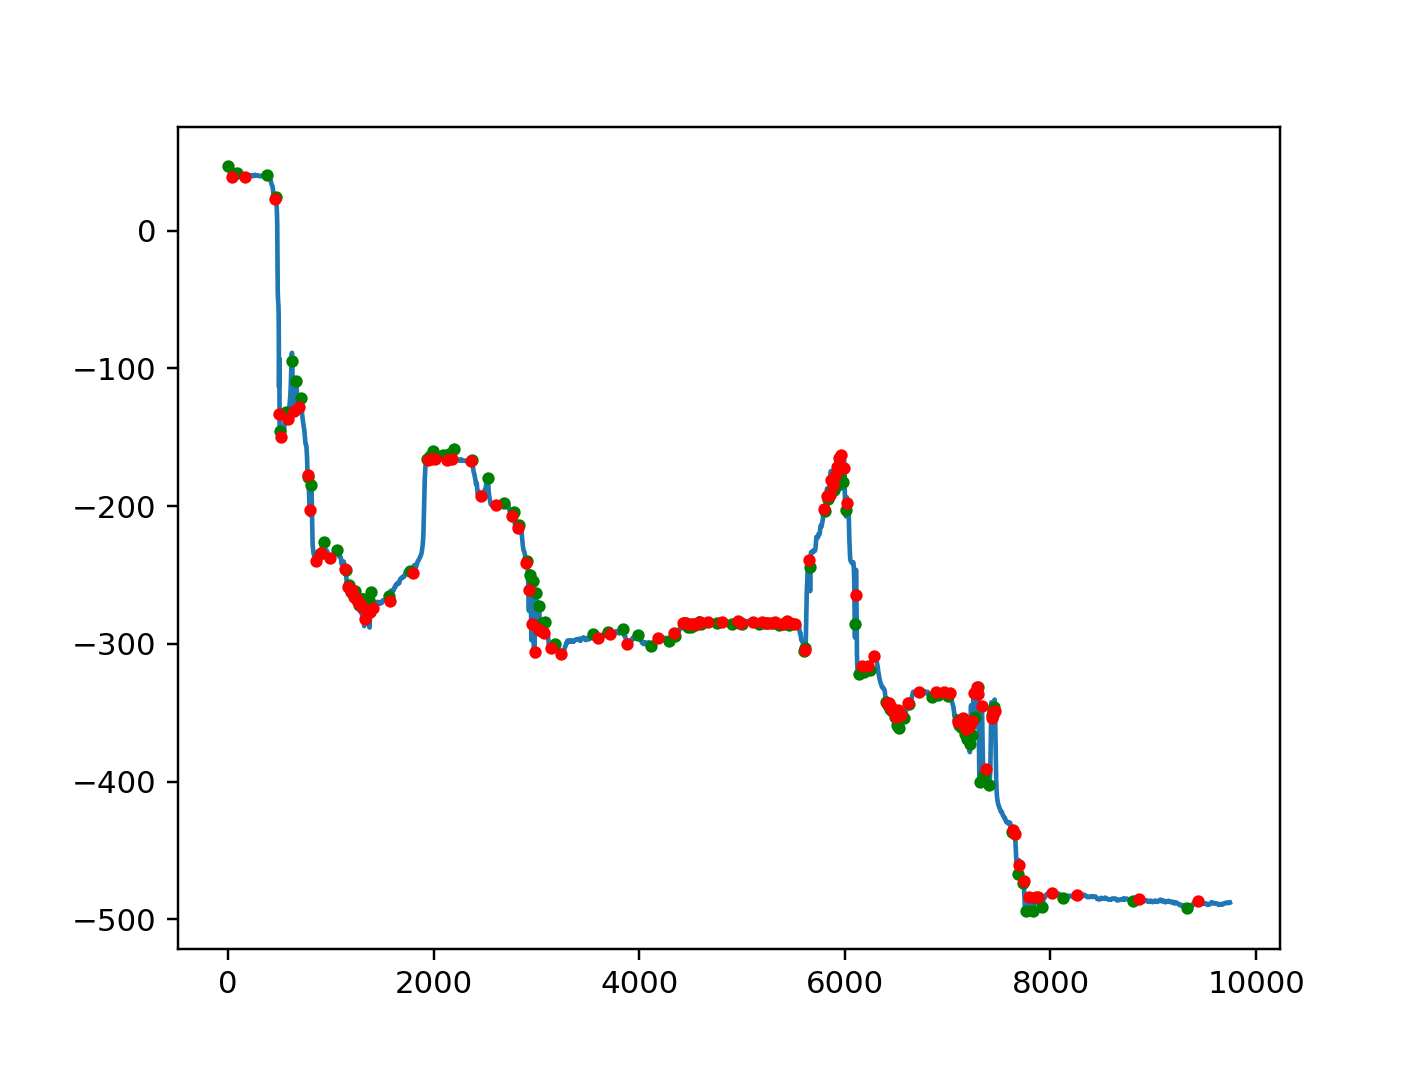

Press any key to continue3
(3, 36)
(22.600000000000001, 37)
0.922529432818
(24.120000000000001, 17)
(26.52, 22)
(29.039999999999999, 18)
0.816034079297
(30.600000000000001, 24)
(32.32, 72)
(35.32, 18)
0.923687317762
(36.520000000000003, 44)
0.70339961345
(39.960000000000001, 10)
0.134974370368
(41.200000000000003, 67)
(46.359999999999999, 82)
(49.799999999999997, 25)
(51.119999999999997, 19)
0.721800552148
(52.039999999999999, 8)
0.00383423121055
(52.520000000000003, 10)
0.610674636377
(53.32, 19)
(54.280000000000001, 13)
0.558371509967
(55.0, 14)
0.411839237953
(55.799999999999997, 13)
0.741211490732
(56.600000000000001, 14)
0.860864825961
(57.640000000000001, 18)
0.846457488004
(58.759999999999998, 13)
0.667217775499
(59.68, 18)
(66.519999999999996, 12)
0.760914947461
(74.719999999999999, 30)
0.159549752687
(81.319999999999993, 16)
(82.560000000000002, 15)
(83.879999999999995, 21)
(87.760000000000005, 36)
(90.040000000000006, 27)
0.758898429598
(91.840000000000003, 166)
0.51068282732

<IPython.core.display.Javascript object>


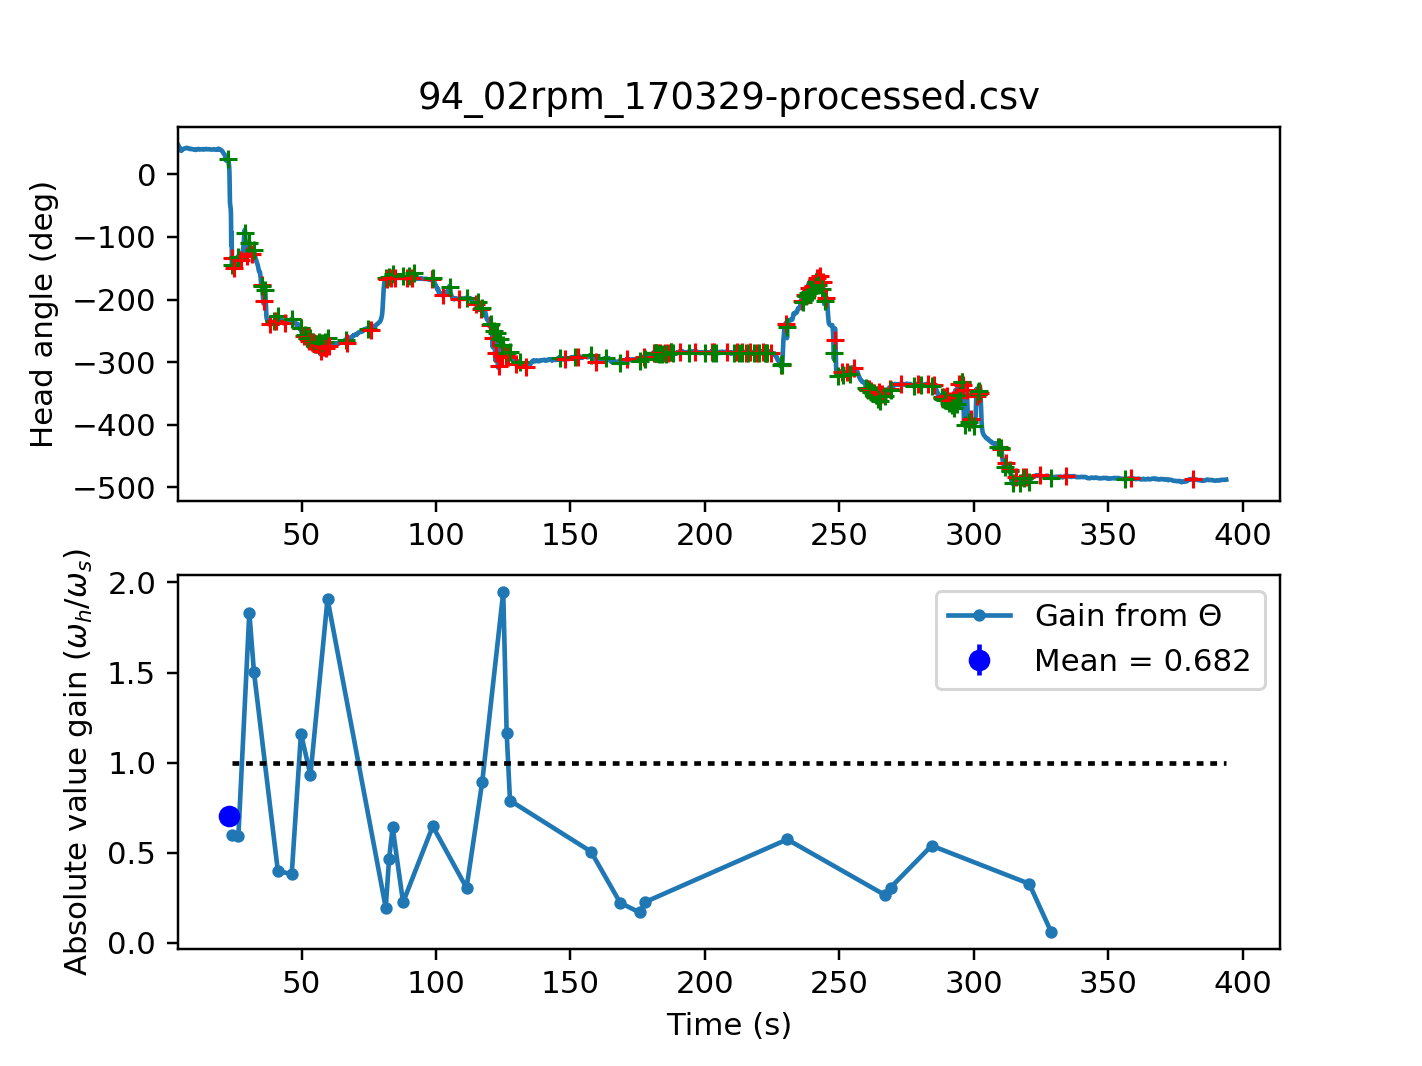

In [10]:
fs = 25
frames = np.array(proc_pd['frames'].astype(float)).astype(int)
T = frames/fs

theta = proc_pd['theta']
theta_deg = theta
theta_deg = theta*180/(2*np.pi)

#smooth angular velocity
w = np.diff(theta_deg)*fs

#lowpass filter to smooth (2/3: not necessary to smooth)
w_smooth = butter_lowpass_lfilter(w,1.5,fs=25)  #my tracker = 0.5, physlet tracker = 1.5
theta_smooth = butter_lowpass_lfilter(theta_deg,1,fs=25)

#Import experimental log file to get rotation direction
exp_log = pd.read_csv('/Users/sazamore/Documents/Visuomotor/experiment_log.csv')
rot_dir = exp_log[(exp_log['Date']==Date) & (exp_log['Speed']==rot_speed/6)]['1st rot'].values[0][:2]
#This line ^ took me 90 minutes to figure out this line
maxes, mins, start_loc, end_loc, halfpt = setNystagmus(theta_deg)
nyst_bool, numevents = findNystagmus(theta_deg, start_loc, end_loc)

In [11]:
if numevents <= 15:
    #there are not enough nystagmus events for me to feel confident they are indeed nystagmus events 
    #TODO: consider length
    print ("No certain nystagmus events found.")
    cont = raw_input("Erase events? (Y/N) ")
    if cont == 'Y' or cont == 'y':
        nyst_bool = np.zeros(np.size(theta_deg),dtype=bool)

<IPython.core.display.Javascript object>


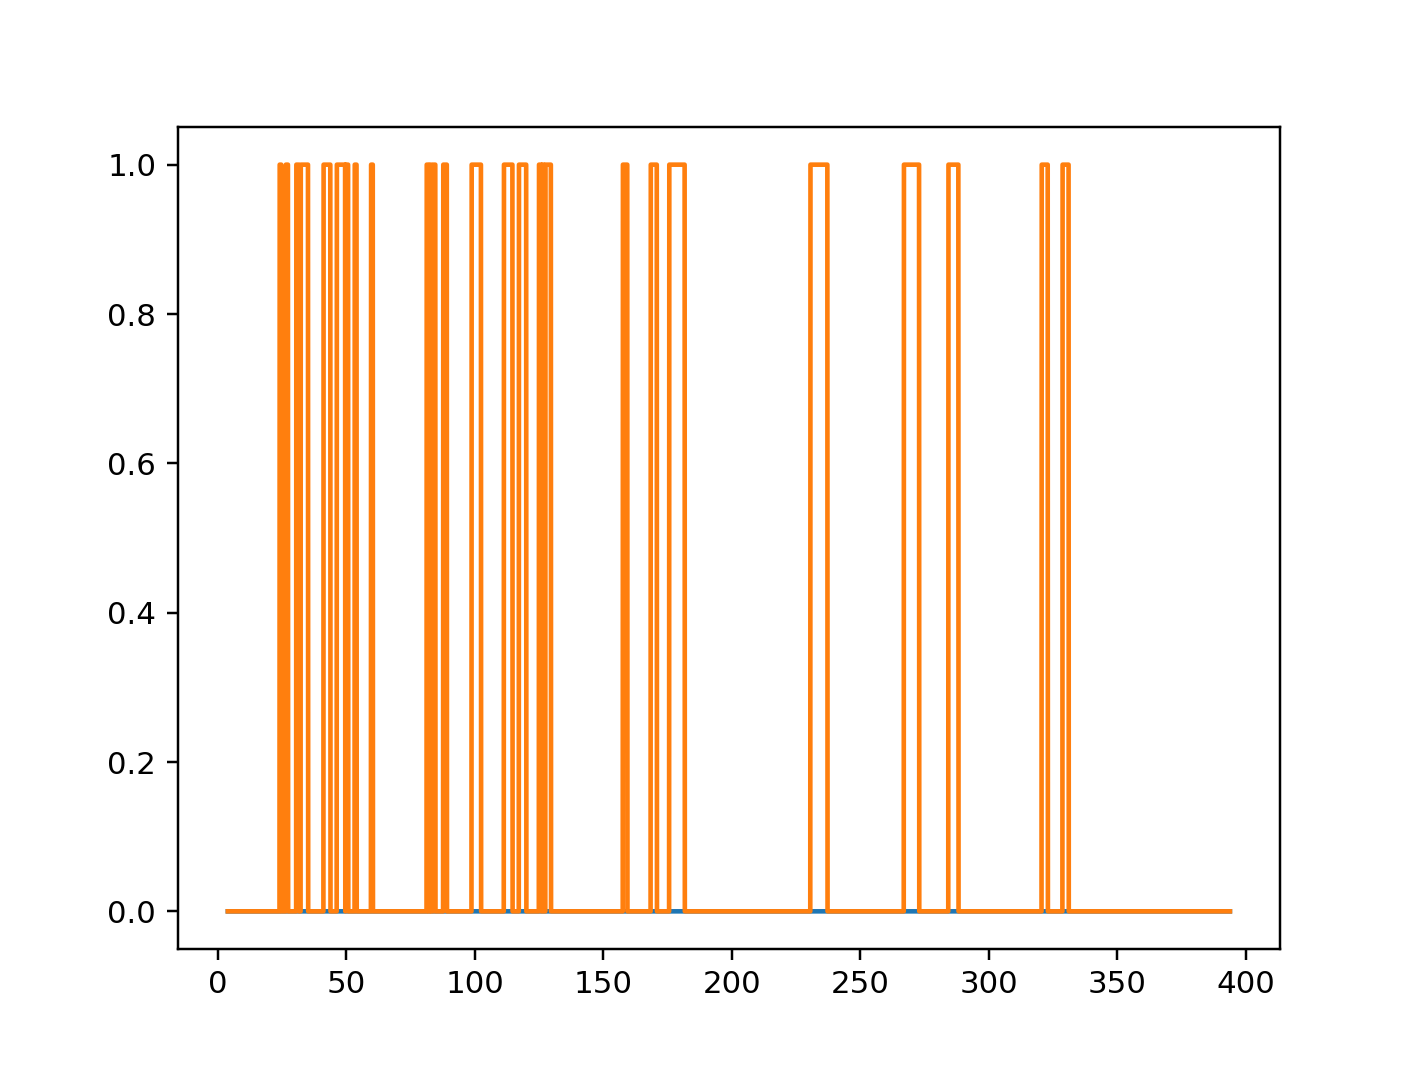

In [12]:
#compare data if you like
plt.figure()
plt.plot(T,proc_pd['nyst_bool'])
plt.plot(T,nyst_bool)

In [219]:
#if you want to combine detection events:
nyst_bool[np.where(proc_pd['nyst_bool'])[0]]=True 

In [384]:
#save processed data
filename[:-3]
saveProcessed(proc_pd, filename)

'94_05rpm_170329-processed.'

In [3]:
proc_pd

,frames,red_x,red_y,red x vel,red y vel,yellow_x,yellow_y,yellow x vel,yellow y vel,vector_dx,vector_dy,vector_mag,theta,view dist,cpd,nyst_bool,hw_bool
0,3012.0,2.045669,-0.654925,0.003014,0.295841,1.855955,-0.383604,0.002222,0.244443,-0.189715,0.271321,0.331069,2.181002,24.220100,1.66431,0.0,0.0
1,3013.0,2.049704,-1.453386,0.002752,-0.347038,1.858946,-1.045205,0.002021,-0.294092,-0.190758,0.408181,0.450556,2.007973,25.144652,1.72784,0.0,0.0
2,3014.0,2.053401,-2.822324,0.001881,-0.402042,1.861680,-2.186366,0.001355,-0.339046,-0.191721,0.635959,0.664229,1.863599,26.602764,1.82803,0.0,0.0
3,3015.0,2.054875,-3.309634,0.001093,-0.337297,1.862660,-2.597264,0.000793,-0.284562,-0.192215,0.712371,0.737847,1.834344,27.040606,1.85812,0.0,0.0
4,3016.0,2.055582,-3.725549,0.000484,-0.218554,1.863099,-2.948188,0.000411,-0.184125,-0.192483,0.777362,0.800838,1.813525,27.447779,1.88609,0.0,0.0
5,3017.0,2.055368,-3.873493,0.000235,-0.123042,1.863255,-3.073518,0.000167,-0.103588,-0.192113,0.799975,0.822719,1.806482,27.583942,1.89545,0.0,0.0
6,3018.0,2.054954,-3.930123,0.000373,-0.061610,1.863183,-3.121757,0.000056,-0.051885,-0.191771,0.808366,0.830802,1.803723,27.649232,1.89994,0.0,0.0
7,3019.0,2.055487,-3.949589,0.000485,-0.023384,1.863159,-3.138775,-0.000002,-0.019642,-0.192328,0.810814,0.833312,1.803696,27.649337,1.89994,0.0,0.0
8,3020.0,2.056121,-3.933500,0.000512,-0.006838,1.863082,-3.125723,-0.000017,-0.005585,-0.193040,0.807776,0.830522,1.805373,27.643125,1.89952,0.0,0.0
9,3021.0,2.056869,-3.927902,0.000401,0.001229,1.863059,-3.120932,-0.000025,0.001369,-0.193810,0.806970,0.829918,1.806502,27.638940,1.89923,0.0,0.0
